# <b>Deep Learning:</b>
# Improving existing segmentators performance with zero-shot segmentators

This Notebook implements the code used in our paper "Improving existing segmentators performance with zero-shot segmentators".

In our study, we used the predicted segmentation masks from state-of-the-art methods **DeepLabV3+** https://github.com/VainF/DeepLabV3Plus-Pytorch and **PVTv2** https://github.com/whai362/PVT.

From these masks, we produce some checkpoints to feed **SAM** (**Segment Anything**, https://github.com/facebookresearch/segment-anything) for *Post-Processing Segmentation Enhancement* or SEEM (**Segment Everything Everywhere All at Once**, https://github.com/UX-Decoder/Segment-Everything-Everywhere-All-At-Once) models.

The **Segment Anything Model (SAM)** produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. It has been trained on a dataset of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks.

Similarly to SAM, **Segment Everything Everywhere All at Once (SEEM)** allows users to easily segment an image using prompts of different types including visual prompts (points, marks, boxes, scribbles and image segments) and language prompts (text and audio), etc. It can also work with any combinations of prompts or generalize to custom prompts.


We devised 4 different methods for producing checkpoints:
 - A: the pixel whose coordinates are, along each dimension, the average of value of all the mask's pixels coordinate
 - B: the center of mass of the mask
 - C: one (or more) pixels drawn (uniformly or not...) randomly inside the mask area
 - D: pixels drawn from the intersection of a uniform grid of fixed step size and the mask. "b" stands for the intersection between the grid and the eroded mask, where the mask is shrinked of 10 pixels.
---

### In order to run the script, you need to:
 - set the path to your data folder    (in "Parameters of the script" cell)
 - set the which type of DeepLabV3+ mask to consider (binary or real valued) (in "Run SAM" cell)

---



### Necessary imports

In [1]:
import torch                    ## pip install torch
import matplotlib.pyplot as plt ## pip install matplotlib
import cv2                      ## pip install opencv-python
from skimage import measure     ## pip install scikit-image
from scipy import ndimage       ## pip install scipy
from tqdm import tqdm           ## pip install tqdm

import numpy as np              ## pip install numpy
import pickle                   ## pip install pickle

import os,glob
import sys
sys.path.append("..")
np.set_printoptions(threshold=sys.maxsize)


###
## to download SAM:
## git clone git@github.com:facebookresearch/segment-anything.git
## cd segment-anything; pip install -e .
###

from segment_anything import sam_model_registry, SamPredictor

### For reproducibility, seed of random generators

In [2]:
torch.manual_seed(0)
np.random.seed(0)

### Helper function for reading images and masks

In [3]:
def read_img(path:str) -> np.ndarray:
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def read_bmask(path:str) -> np.ndarray:
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.0

def read_rmask(path:str) -> np.ndarray:
    return cv2.imread(path, cv2.IMREAD_UNCHANGED) 

def get_data(paths:list) -> list:
    img_path, gt_mask_path, dplabv3_bmask_path, dplabv3_rmask_path = paths
    img           = read_img(img_path)
    gt_mask       = read_bmask(gt_mask_path)
    dplabv3_bmask = read_bmask(dplabv3_bmask_path)
    dplabv3_rmask = read_rmask(dplabv3_rmask_path)
    assert img.shape[:2] == gt_mask.shape == \
           dplabv3_bmask.shape == dplabv3_rmask.shape[:2], \
            f"Error: shape mismatch, {img.shape[:2]} {gt_mask.shape} {dplabv3_bmask.shape} {dplabv3_rmask.shape[:2]}"
    return img, gt_mask, dplabv3_bmask, dplabv3_rmask

### Helper functions for displaying points, boxes, and masks.

In [4]:
def show_mask(mask: np.ndarray, ax, random_color:bool=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords:np.ndarray, labels:np.ndarray, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) # this is if you want the star
    #ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=10, edgecolor='green', linewidth=1.25) # this is if you want the dot
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def draw_img(img:np.ndarray, input_point:np.ndarray=None, input_label:np.ndarray=None, \
             mask: np.ndarray=None, title:plt.title = None, plt_show:bool=True):
    plt.clf()
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    if mask is not None:
        show_mask(mask, plt.gca())
    if input_point is not None and input_label is not None:
        show_points(input_point, input_label, plt.gca())
    if title is not None:
        plt.title(title, fontsize=18)
    plt.axis('off')
    if plt_show:
        plt.show()
        
def draw_results(masks:list, scores:list, gt_mask:np.ndarray, \
                 input_point:np.ndarray, input_label:np.ndarray):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        iou = get_iou(mask, gt_mask)
        title = f"Mask {i+1}, Score: {score:.3f}, IoU: {iou:.3f}"
        draw_img(img, input_point, input_label, mask, title)

### Helper function for computing how many blobs a mask contains

In [5]:
def get_mask_of_blobs(mask: np.ndarray) -> np.ndarray:
    # compute how many blobs a mask contains
    # @return: a mask in which each pixel is assigned a blob ID
    mask_of_blobs = measure.label(mask)
    return mask_of_blobs

### Helper function for logging

In [6]:
def log(paths: tuple):
    img_path, gt_mask_path, dplabv3_bmask_path, dplabv3_rmask_path = paths
    print("img_path          :", img_path)
    print("gt_mask_path      :", gt_mask_path)
    print("dplabv3_bmask_path:", dplabv3_bmask_path)
    print("dplabv3_rmask_path:", dplabv3_rmask_path)

### Function to compute the Metrics
(between a predicted mask and a Ground Truth mask)

In [98]:
class Metrics():
    eps=np.finfo(np.double).eps
    
    def reset(self):
        self.ious, self.maes, self.dices, self.wfms, self.emes = [], [], [], [], []
    
    def __init__(self):
        self.reset()
    
    def step(self, pred, GT):
        iou       = self.get_iou(pred, GT)
        dice      = self.get_dice(pred, GT)
        mae       = self.compute_mae(pred, GT)
        fscore    = self.FbetaMeasure(pred.astype(bool), GT.astype(bool))
        e_measure = self.EMeasure(pred.astype(bool), GT.astype(bool))
        self.ious.append(iou)
        self.dices.append(dice)
        self.maes.append(mae)
        self.wfms.append(fscore)
        self.emes.append(e_measure)
        
    def step_locuste(self, pred, GT):
        iou       = self.get_iou_locuste(pred, GT)
        dice      = self.get_dice_locuste(pred.astype(bool), GT.astype(bool))
        mae       = self.compute_mae(pred, GT)
        e_measure = self.EMeasure(pred.astype(bool), GT.astype(bool))
        fscore    = self.FbetaMeasure(pred.astype(bool), GT.astype(bool))
        self.ious.append(iou)
        self.dices.append(dice)
        self.maes.append(mae)
        self.wfms.append(fscore)
        self.emes.append(e_measure)
    
    def get_iou(self, pred, gt, beta=1):
        y_pred_bool = pred.astype(bool)
        y_true_bool = gt.astype(bool)
        tp = np.logical_and(y_true_bool, y_pred_bool).sum()
        tn = np.logical_and(~y_true_bool, ~y_pred_bool).sum()
        fp = np.logical_and(~y_true_bool, y_pred_bool).sum()
        fn = np.logical_and(y_true_bool, ~y_pred_bool).sum()
        iou = tp / (tp + fn + fp)

        return iou

    def get_iou_locuste(self, pred, target, n_classes = 2):
        return jaccard_score(target.reshape(-1).astype(bool), pred.reshape(-1).astype(bool))

    def get_dice(self, pred, gt):
        y_pred_bool = pred.astype(bool)
        y_true_bool = gt.astype(bool)

        tp = np.logical_and(y_true_bool, y_pred_bool).sum()
        tn = np.logical_and(~y_true_bool, ~y_pred_bool).sum()
        fp = np.logical_and(~y_true_bool, y_pred_bool).sum()
        fn = np.logical_and(y_true_bool, ~y_pred_bool).sum()

        dice = 2*tp / (2*tp + fn + fp)

        return dice

    def _calConfusion(self, pred, GT):
        TP=np.sum(pred[GT]==1)
        FP=np.sum(pred[~GT]==1)
        TN=np.sum(pred[~GT]==0)
        FN=np.sum(pred[GT]==0)
        return TP,FP,TN,FN

    def get_dice_locuste(self, pred, GT):
        tp, fp, tn, fn = _calConfusion(pred, GT)
        return (2.0 * tp) / (2.0 * tp + fp + fn + 1e-7)

    def compute_mae(self, pred: np.ndarray, gt: np.ndarray) -> np.ndarray:
        mae = np.mean(np.abs(pred - gt))
        return mae
    
    ## F-Measure
    def FbetaMeasure(self, pred, GT, beta= sqrt(0.3)):
        TP,FP,TN,FN=_calConfusion(pred, GT)
        P=TP/(TP+FP+1e-8) #precision
        R=TP/(TP+FN+1e-8) #recall
        Fbeta=(beta**2+1)*P*R/((beta**2)*P+R+1e-8)
        return Fbeta
    
    ## E-Measure
    def _EnhancedAlignmnetTerm(self, align_Matrix):
        enhanced=((align_Matrix+1)**2)/4
        return enhanced

    def _AlignmentTerm(self, dGT, dpred):
        mean_dpred=np.mean(dpred)
        mean_dGT=np.mean(dGT)
        align_dpred=dpred-mean_dpred
        align_dGT=dGT-mean_dGT
        align_matrix=2*(align_dGT*align_dpred)/(align_dGT**2+align_dpred**2+self.eps)
        return align_matrix

    def EMeasure(self, pred, GT):
        dGT,dpred=GT.astype(np.float64),pred.astype(np.float64)
        if np.sum(GT)==0:#completely black
            enhanced_matrix=1-dpred
        elif np.sum(~GT)==0:
            enhanced_matrix=dpred
        else:
            align_matrix=self._AlignmentTerm(dGT,dpred)
            enhanced_matrix=self._EnhancedAlignmnetTerm(align_matrix)
        rows,cols= GT.shape
        score=np.sum(enhanced_matrix)/(rows*cols-1+self.eps)
        return score
    
    def get_results(self) -> (float, float, float, float, float):
        return np.array(self.ious).mean(), np.array(self.dices).mean(), np.array(self.maes).mean(), np.array(self.wfms).mean(), np.array(self.emes).mean()


### Functions for the sampling of the checkpoints.

In [28]:

class Sampler:
    verbose = True
    sampling_step = None
    min_blob_count = None
    def __init__(self, verbose, sampling_step, min_blob_count):
        self.verbose        = verbose
        self.sampling_step  = sampling_step
        self.min_blob_count = min_blob_count
    
    def sample_pixels(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        # draw a pix for each blob
        input_point, input_label = [], []
        blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
        gt_fl = mask.flatten()
        for bl, bs in zip(blob_labels, blob_sample):
            mask_bool = (mask_of_blobs==bl)
            count = mask_bool.sum()
            if gt_fl[bs]>=1.0 and count>self.min_blob_count: ## it's not a background blob or a false blob
                x_center, y_center = np.argwhere(mask_bool).sum(0)/count
                x_center, y_center = int(x_center) % mask.shape[0], int(y_center) % mask.shape[1]
                input_point.append([y_center, x_center])
                input_label.append(1)
                print(f"blob #{bl} drawn point: {[x_center, y_center]}") if self.verbose else None

        # no mask? pick the center pixel of image
        if len(input_point) == 0:
            input_point, input_label = [[mask.shape[1]//2, mask.shape[0]//2]], [1]

        return np.array(input_point), np.array(input_label)
    
    def sample_pixels_center_of_mass(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        # draw a pix for each blob
        input_point, input_label = [], []
        blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
        gt_fl = mask.flatten()
        for bl, bs in zip(blob_labels, blob_sample):
            mask_bool = (mask_of_blobs==bl)
            count = mask_bool.sum()
            if gt_fl[bs]>=1.0 and count>self.min_blob_count: ## it's not a background blob or a false blob
                x_center, y_center = ndimage.center_of_mass(mask_bool)
                input_point.append([y_center, x_center])
                input_label.append(1)
                print(f"blob #{bl} drawn point: {[x_center, y_center]}") if self.verbose else None

        # no mask? pick the center pixel of image
        if len(input_point) == 0:
            input_point, input_label = [[mask.shape[1]//2, mask.shape[0]//2]], [1]
            print(f"empty blob -> {input_point}") if self.verbose else None

        return np.array(input_point), np.array(input_label)

    def sample_pixels_random(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        # draw a pix for each blob
        input_point, input_label = [], []
        blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
        gt_fl = mask.flatten()
        for bl, bs in zip(blob_labels, blob_sample):
            mask_bool = (mask_of_blobs==bl)
            count = mask_bool.sum()
            if gt_fl[bs]>=1.0 and count>self.min_blob_count: ## it's not a background blob or a false blob
                indices = np.argwhere(mask_bool)
                random_index = np.random.choice(indices.shape[0])
                x_center, y_center = indices[random_index]
                input_point.append([y_center, x_center])
                input_label.append(1)
                print(f"blob #{bl} drawn point: {[x_center, y_center]}") if self.verbose else None

        # no mask? sample a random point
        if len(input_point) == 0:
            input_point, input_label = [ \
                [np.random.randint(0, mask.shape[1]),   \
                 np.random.randint(0, mask.shape[0])]], \
            [1]

        return np.array(input_point), np.array(input_label)

    def get_grid(self, mask, offset_px_x, offset_px_y):
        row = np.zeros(mask.shape, dtype=int)
        col = np.zeros(mask.shape, dtype=int)

        for i in range(offset_px_y, row.shape[0], self.sampling_step):
            row[i, :] = 1
        for i in range(offset_px_x, col.shape[1], self.sampling_step):
            col[:, i] = 1
        res = row & col
        return res
    
    def sample_pixels_grid(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):

        # draw a pix for each blob
        input_point = []
        offset_px_x = 0
        offset_px_y = 0
        while len(input_point)==0 and offset_px_y < self.sampling_step:
            res = self.get_grid(mask, offset_px_x, offset_px_y)

            input_point = np.argwhere(res & mask.astype(np.int64))
            input_point[:, (0, 1)] = input_point[:, (1, 0)]
            
            offset_px_x += 1
            if offset_px_x>self.sampling_step:
                offset_px_x = 0
                offset_px_y += 1

        # STILL no mask? sample a random point
        if len(input_point) == 0:
            return self.sample_pixels_random(mask_of_blobs, mask)

        input_label = [1 for _ in input_point]
        

        return np.array(input_point), np.array(input_label)
    
    def sample_pixels_eroded_grid(self, mask_of_blobs: np.ndarray, mask: np.ndarray) -> (np.ndarray, np.ndarray):
        
        input_point = []
        offset_px_x = 0
        offset_px_y = 0
        
        while len(input_point)==0 and offset_px_y < self.sampling_step:
            res = self.get_grid(mask, offset_px_x, offset_px_y)
            erode_size = 10
        
            while True:
                # Erode the mask
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erode_size, erode_size))
                eroded_mask = cv2.erode(mask, kernel)

                input_point = np.argwhere(res & eroded_mask.astype(np.int64))
                input_point[:, (0, 1)] = input_point[:, (1, 0)]

                blob_labels, blob_sample = np.unique(mask_of_blobs, return_index=True)
                gt_fl = mask.flatten()

                blobs = np.zeros(blob_labels.shape[0], dtype=np.float32)
                for i, (bl, bs) in enumerate(zip(blob_labels, blob_sample)):
                    mask_bool = (mask_of_blobs==bl)
                    count = mask_bool.sum()
                    if not (gt_fl[bs]>=1.0 and count>self.min_blob_count): ## it's not a background blob or a false blob
                        blobs[i] = -1

                for i in range(input_point.shape[0]):
                    fl_ip = input_point[i][0]*mask.shape[1] + input_point[i][1]
                    idx = mask_of_blobs[input_point[i][1], input_point[i][0]]
                    blobs[idx]=1.0
                
                if not np.any(blobs==0.0) or erode_size==1:
                    break
                erode_size -= 1
            
            offset_px_x += 1
            if offset_px_x>self.sampling_step:
                offset_px_x = 0
                offset_px_y += 1
            
        
        input_label = [1 for _ in input_point]

        # still no mask? sample a random point
        if len(input_point) == 0:
            return self.sample_pixels_grid(mask_of_blobs, mask)

        return np.array(input_point), np.array(input_label)
    
    def sample(self, mode, border_mode, mask_of_blobs: np.ndarray, mask: np.ndarray):
        if mode=="A":
            return self.sample_pixels(mask_of_blobs, mask)
        elif mode=="B":
            return self.sample_pixels_center_of_mass(mask_of_blobs, mask)
        elif mode=="C":
            return self.sample_pixels_random(mask_of_blobs, mask)
        elif mode=="D":
            if border_mode=="on":
                return self.sample_pixels_eroded_grid(mask_of_blobs, mask)
            else:
                return self.sample_pixels_grid(mask_of_blobs, mask)


## visualize an example

<Figure size 640x480 with 0 Axes>

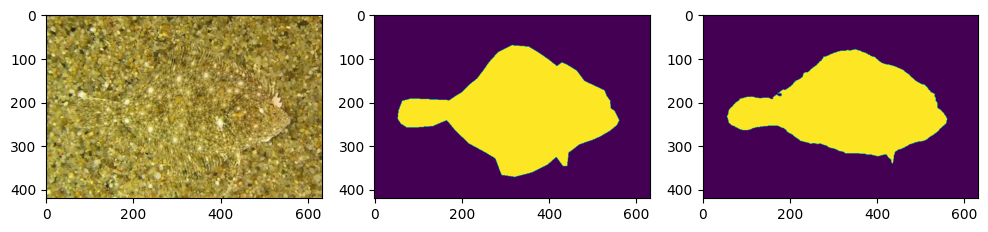

In [10]:
img           = read_img ("images/test/camourflage_00012.jpg")
gt_mask       = read_bmask("images/labels/1.bmp")
dplabv3_bmask = read_bmask("images/deeplab_masks/1.bmp")


# for each computed mask, show the superposition with the original image
# and SAM's predicted score and IoU wrt Ground Truth mask
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
axes[0].imshow(img)
axes[1].imshow(gt_mask)
axes[2].imshow(dplabv3_bmask)
fig.tight_layout()
plt.show()

### Parameters of the script

In [40]:
verbose           = False

## Data settings
dataset_path = "/home/fusy/Documents/SAM/PAPER-work/data/" ## Put your PATH here!


## Run SAM

Predict with `SamPredictor.predict`. The model returns
 - masks  (`masks.shape  # (number_of_masks) x H x W) ` )
 - quality predictions for those masks
 - low resolution mask logits that can be passed to the next iteration of prediction.

The `predict()` function accepts three parameters (among many):

 - `point_coords`: an np.ndarray of 2D pixels that will provide SAM the checkpoints/seeds of the object to segment
 - `point_labels`: is the corresponding pixel a pixel belonging to the object (1) or not (0) ?

 - With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [29]:
def loadinfo(dataset, dataset_path):
    pvtv2_folder = None
    if dataset=="CAMO":
        test_folder    = os.path.join(dataset_path, "CAMO/test")
        gt_folder      = os.path.join(dataset_path, "CAMO/labels")
        dplabv3_folder = os.path.join(dataset_path, "CAMO/deeplab_masks")
        pvtv2_folder   = os.path.join(dataset_path, "CAMO/PVTtransformersCAMO")
        img_ext = ".jpg"
    elif dataset=="portrait":
        test_folder    = os.path.join(dataset_path, "portrait/TE")
        gt_folder      = os.path.join(dataset_path, "portrait/maskTE")
        dplabv3_folder = os.path.join(dataset_path, "portrait/res50pretr1structure_DA1.mat")
        img_ext = ".png"
    elif dataset=="locuste":
        test_folder    = os.path.join(dataset_path, "Locuste/Image_size")
        gt_folder      = os.path.join(dataset_path, "Locuste/maskTE")
        dplabv3_folder = os.path.join(dataset_path, "Locuste/res50pretr1dice_DA1.mat")
        img_ext = ".jpg"
    elif dataset=="ribs":
        test_folder    = os.path.join(dataset_path, "Ribs/imgTE")
        gt_folder      = os.path.join(dataset_path, "Ribs/maskTE")
        dplabv3_folder = os.path.join(dataset_path, "Ribs/res50pretr1dice_DA1.mat")
        img_ext = ".png"
    return test_folder, gt_folder, dplabv3_folder, pvtv2_folder, img_ext
    

In [43]:
def loadpaths(test_folder, gt_folder, src_folder):
    ## Load input images ##
    test_imgs = glob.glob(os.path.join(test_folder, '*'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in test_imgs]
    test_imgs = [test_imgs[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]

    ## Load GT masks ##
    gt_masks = glob.glob(os.path.join(gt_folder, '*'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in gt_masks]
    gt_masks = [gt_masks[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]

    ## Load DeepLabV3+ produced binary masks ##
    src_bmasks = glob.glob(os.path.join(src_folder, '*.bmp'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in src_bmasks]
    src_bmasks = [src_bmasks[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]

    # ## Load DeepLabV3+ produced 3D masks ##
    src_rmasks = glob.glob(os.path.join(src_folder, '*.png'))
    bn = [os.path.basename(path[:-4]).zfill(6) for path in src_rmasks]
    src_rmasks = [src_rmasks[i] for i in sorted(range(len(bn)), key=lambda k: bn[k])]
    
    return test_imgs, gt_masks, src_bmasks, src_rmasks

In [48]:

def perform(predictor, model_type, source_mask, dataset, points_sampling_mode, sampling_step, border_mode):
    global verbose
    min_blob_count = 20 if dataset=="portrait" else 10
    verbose = False
    test_folder, gt_folder, dplabv3_folder, pvtv2_folder,\
              img_ext = loadinfo(dataset, dataset_path)
    
    if source_mask=="pvtv2":
        test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths(test_folder, gt_folder, pvtv2_folder)
    else:
        test_imgs, gt_masks, src_bmasks, src_rmasks = loadpaths(test_folder, gt_folder, dplabv3_folder)

    assert len(test_imgs) == len(gt_masks) == len(src_bmasks) == len(src_rmasks),\
              f"unbalanced datasets! {len(test_imgs)} {len(gt_masks)} {len(src_rmasks)}"

    print("len of files:", len(test_imgs)) if verbose else None
    
    output_folder = os.path.join(dataset_path, "binary_masks", model_type, dataset, deeplab_or_oracle, \
                            points_sampling_mode + (("_" + str(sampling_step)) if points_sampling_mode=="D" else "") \
                            + ("_bm" if border_mode=="on" and points_sampling_mode=="D" else ""))

    toiterate = zip(test_imgs, gt_masks, src_bmasks, src_rmasks)
    
    sampler = Sampler(verbose, sampling_step, min_blob_count)
    metrics = Metrics()

    for idx, paths in tqdm(enumerate(toiterate)):
        print(f" - img idx {str(idx+1).zfill(6)}/{len(test_imgs)}:") if verbose else None
        
        # Get paths
        img_path, gt_mask_path, src_bmask_path, src_rmask_path = paths
        log(paths) if verbose else None
            
        # Load images from disk using paths
        img           = read_img(img_path)
        gt_mask       = read_bmask(gt_mask_path)
        src_bmask = read_bmask(src_bmask_path)
        src_rmask = read_rmask(src_rmask_path)
        assert img.shape[:2] == gt_mask.shape == \
            src_bmask.shape == src_rmask.shape[:2], "Error: shape mismatch"
        
        # mask_to_sample = dplabv3_bmask
        if source_mask=="oracle":
            mask_to_sample = gt_mask
        else:
            mask_to_sample = src_bmask

        # Count the number of distinct labels (it corresponds to the number of blobs)
        mask_of_blobs = get_mask_of_blobs(mask_to_sample)
        
        # Sample the checkpoints (at least one for blob)
        input_point, input_label = sampler.sample(points_sampling_mode, border_mode, mask_of_blobs, mask_to_sample)
        
        print("setting image on predictor", end="... ")  if verbose else None
        predictor.set_image(img)
        
        print("predicting", end="... ")  if verbose else None
        masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=True,
            return_logits=True
        )
        torch.cuda.empty_cache()
        
        best_score_idx = np.argmax(scores)
        binary_mask = masks[best_score_idx] > 0
        
        # # TO VISUALIZE computed mask, show the superposition with the original image
        # # and SAM's predicted score and IoU wrt Ground Truth mask
        #
        # plt.clf()
        # fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
        # axes[0].imshow(img)
        # axes[0].scatter([input_point[:, 0]], [input_point[:, 1]], color='green', marker='*', s=100, edgecolor='white', linewidth=1.25) # this is if you want the star
        # axes[1].imshow(gt_mask)
        # axes[2].imshow(binary_mask)
        # fig.tight_layout()
        # plt.show()
        
        ## this is how we saved the produced masks
        # cv2.imwrite(out_mask_path, masks[best_score_idx]*255)

        ## COMPUTE METRICS
        if dataset=="locuste":
            metrics.step_locuste(binary_mask, gt_mask)

        else:
            metrics.step(binary_mask, gt_mask)


    iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = metrics.get_results()

    print(f"average iou: {iou_avg}")
    print(f"average dice: {dice_avg}")
    print(f"average mae: {mae_avg}")
    print(f"average weighted f-measure: {wfm_avg}")
    print(f"average e-measure: {eme_avg}")



In [13]:
def perform_all(dataset_name, predictor, model_type, source_mask, ):
    with torch.no_grad():
        perform(predictor, model_type, source_mask, dataset_name, "A", None, None)
        perform(predictor, model_type, source_mask, dataset_name, "B", None, None)
        perform(predictor, model_type, source_mask, dataset_name, "C", None, None)
        perform(predictor, model_type, source_mask, dataset_name, "D", 10, "on")
        perform(predictor, model_type, source_mask, dataset_name, "D", 30, "on")
        perform(predictor, model_type, source_mask, dataset_name, "D", 50, "on")
        perform(predictor, model_type, source_mask, dataset_name, "D", 100, "on")
        perform(predictor, model_type, source_mask, dataset_name, "D", 10, "off")
        perform(predictor, model_type, source_mask, dataset_name, "D", 30, "off")
        perform(predictor, model_type, source_mask, dataset_name, "D", 50, "off")
        perform(predictor, model_type, source_mask, dataset_name, "D", 100, "off")

## USE VIT-L

In [ ]:
device = "cuda" # ["cuda", "cpu"]

# predictor=None
sam_checkpoint = os.path.join(dataset_path, "pretrained_models", "sam_vit_l_0b3195.pth")
model_type = "vit_l"
source_mask = "oracle" # "oracle", "deeplab", "pvtv2"

# print(f"creating sam {model_type} and moving it to device")  if verbose else None
# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
# print("creating predictor") if verbose else None
# predictor = SamPredictor(sam) 

# CHOOSE ONE (OR MANY)

perform_all("CAMO", predictor, model_type, source_mask)
# perform_all("portrait", predictor, model_type, source_mask)
# perform_all("locuste", predictor, model_type, source_mask)
# perform_all("ribs", predictor, model_type, source_mask)

## USE VIT-H

In [ ]:
device = "cuda" # ["cuda", "cpu"]
verbose = True
predictor=None
sam_checkpoint = os.path.join(dataset_path, "pretrained_models", "sam_vit_h_4b8939.pth")
model_type = "default"
source_mask = "deeplab" # ["oracle", "deeplab", "pvtv2"]

print(f"creating sam {model_type} and moving it to device")  if verbose else None
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
print("creating predictor") if verbose else None
predictor = SamPredictor(sam) 

# CHOOSE ONE (OR MANY)

perform_all("CAMO", predictor, model_type, source_mask)
# perform_all("portrait", predictor, model_type, source_mask)
# perform_all("locuste", predictor, model_type, source_mask)
# perform_all("ribs", predictor, model_type, source_mask)

## evaluate fusion performance

In [104]:
model_type = "default"
dataset = "CAMO"
source_mask = "pvtv2" # "oracle", "deeplab", "pvtv2"
points_sampling_mode = "D"
sampling_step = 50
border_mode = "off"
pred_path  = os.path.join("../data/binary_masks", model_type, dataset, deeplab_or_oracle, \
                points_sampling_mode + (("_" + str(sampling_step)) if points_sampling_mode=="D" else "") \
                + ("_bm" if border_mode=="on" and points_sampling_mode=="D" else ""))

metrics = Metrics()
metrics.reset()
test_folder, gt_folder, dplabv3_folder, pvtv2_folder,\
              img_ext = loadinfo(dataset, dataset_path)

if source_mask=="pvtv2":
    _, gt_masks, src_bmasks, src_rmasks = loadpaths(test_folder, gt_folder, pvtv2_folder)
else:
    _, gt_masks, src_bmasks, src_rmasks = loadpaths(test_folder, gt_folder, dplabv3_folder)

toiterate = zip(gt_masks, src_bmasks, src_rmasks)


for idx, paths in tqdm(enumerate(toiterate)):
    print(f" - img idx {str(idx+1).zfill(6)}/{len(test_imgs)}:") if verbose else None

    # Get paths
    gt_mask_path, src_bmask_path, src_rmask_path = paths
    
    # Load images from disk using paths
    gt_mask   = read_bmask(gt_mask_path).astype(np.float32)
    src_bmask = read_bmask(src_bmask_path).astype(np.float32)
    src_rmask = read_bmask(src_rmask_path).astype(np.float64) * 255
    assert gt_mask.shape == src_bmask.shape \
            == src_rmask.shape[:2], "Error: shape mismatch"
    
    pred_mask = f"{pred_path}/{idx+1}.jpg"
    img = cv2.imread(pred_mask)[:, :, 0]
    pred_mask = abs(255 - img.astype('uint8'))

    pred_mask = ((pred_mask + 2*src_rmask)/3).astype(np.uint8) < 128

    # plt.clf()
    # fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # axes[0].imshow(gt_mask)
    # axes[1].imshow(src_bmask)
    # axes[2].imshow(pred_mask)
    # fig.tight_layout()
    # plt.show()
    # break
    
    metrics.step(pred_mask, gt_mask)
    
iou_avg, dice_avg, mae_avg, wfm_avg, eme_avg  = metrics.get_results()
print(len(metrics.ious))
print(f"average iou      : {iou_avg*100:5.2f}")
print(f"average dice     : {dice_avg*100:5.2f}")
print(f"average mae      : {mae_avg*100:5.2f}")
print(f"average f-measure: {wfm_avg*100:5.2f}")
print(f"average e-measure: {eme_avg*100:5.2f}")




250it [00:05, 44.66it/s]

250
average iou      : 73.31
average dice     : 81.88
average mae      :  5.60
average f-measure: 83.32
average e-measure: 90.00
